In [1]:
import requests
import json
from os import path
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### API CONFIGUATION

In [2]:
BASE_URL = "https://rest.coinapi.io/"

API_KEY = "AE6EB1CB-8CD4-400E-80A6-A3A8792CB183"

### API SERVICE

In [83]:
class APIService:
    def __init__(self, assets, ticker_period):
        self.assets = assets
        self.ticker_period = ticker_period
        self.headers = {
            'Accept': 'text/plain',
            'X-CoinAPI-Key': API_KEY
        }
        self.base_url = BASE_URL
        self.payload = {}
     
    # The objective is to combine intervals of days following a quota of 100 days according to start_date and end_date (since the API collects on 100 days/request).
    # date_start / date_end: date objects
    # max_days : int
    # start : 1/5/2024
    # End : 19/9/2024
    # -> [[1/5/2024, 10/08/2024], [11/08/2024, 19/09/2024]] 
    
    def get_dates_intervals(self, start_date, end_date, max_days):
        diff = end_date - start_date
        diff_days = abs(diff.days)
        dates_intervals = []
        interval_begin_date = start_date

        while diff_days > 0:
            nb_days_to_add = max_days - 1
            if diff_days < max_days - 1:
                nb_days_to_add = diff_days
            interval_end_date = interval_begin_date + timedelta(nb_days_to_add)
            dates_intervals.append([interval_begin_date, interval_end_date])
            diff_days -= nb_days_to_add + 1
            interval_begin_date = interval_end_date + timedelta(1)

        return dates_intervals

    # Call the API and display the result as it is.
    
    def get_exchange_rates(self, start_date, end_date):
        start_date_str = start_date.strftime("%Y-%m-%d")
        end_date_str = (end_date + timedelta(1)).strftime("%Y-%m-%d")

        url = f"{self.base_url}v1/exchangerate/{self.assets}/history?period_id={self.ticker_period}&time_start={start_date_str}T00:00:00&time_end={end_date_str}T00:00:00"

        response = requests.request("GET", url, headers=self.headers, data=self.payload)

        if response.status_code == 200:
            return json.loads(response.text)
        else:
            print(f"API Error: {response.status_code}")
            return None

    # extended : start and end dates can be separeted more than 100 days
    
    def get_exchange_rates_extended(self, start_date, end_date):
        rates = []
        date_intervals = self.get_dates_intervals(start_date, end_date, 100)
        for interval in date_intervals:
            interval_rates = self.get_exchange_rates(interval[0], interval[1])
            if interval_rates:
                rates += interval_rates
        return rates

    def get_filtered_rates(self, start_date, end_date):
        rates = self.get_exchange_rates_extended(start_date, end_date)
        return self.filter_inconsistent_rate_values(rates)

    # I want to reduce error ranges on highs, lows and closes

    def filter_inconsistent_rate_values(self, input_rates):
        def rate_is_inconsistent(rate):
            v = rate["rate_open"]
            vmin = v / 10
            vmax = v * 10
            if not vmin <= rate["rate_close"] <= vmax:
                return True
            if not vmin <= rate["rate_high"] <= vmax:
                return True
            if not vmin <= rate["rate_low"] <= vmax:
                return True
            return False

        filtered_rates = []
        for i, r in enumerate(input_rates):
            if rate_is_inconsistent(r):
                # take the day before and the day after
                reference_rate = input_rates[i - 1] if i > 0 else input_rates[i + 1]
                r["rate_open"] = reference_rate["rate_open"]
                r["rate_close"] = reference_rate["rate_close"]
                r["rate_high"] = reference_rate["rate_high"]
                r["rate_low"] = reference_rate["rate_low"]
            filtered_rates.append(r)
        return filtered_rates

### RATES DATA MANAGER

In [85]:
class RatesDataManager:
    def __init__(self, api_service):
        self.api_service = api_service

    def load_json_data_from_file(self, filename):
        """Load rates data from the JSON file."""
        with open(filename, "r") as f:
            return json.load(f)

    def save_rates_data_to_file(self, filename, rates_data):
        """Save the rates data to a JSON file."""
        with open(filename, "w") as f:
            json.dump(rates_data, f)

    def convert_rates_to_date_value_format(self, rates_data):
        """Convert rates data to the desired date-value format."""

        return [{"Date": r["time_period_start"][:10], "Close": r["rate_close"]} for r in rates_data]

    def get_and_manage_rates_data(self, assets, start_date, end_date, ticker_period):
        """Helper to generate the file name for saving JSON data."""
        data_filename = assets.replace("/", "_") + ".json"
        rates = []

        if path.exists(data_filename):
            rates = self.load_json_data_from_file(data_filename)
            if rates:
                print("The json file exists")
                # Convert str date to date objet
                saved_data_date_start = datetime.strptime(rates[0]["Date"], "%Y-%m-%d").date()
                saved_data_date_end = datetime.strptime(rates[-1]["Date"], "%Y-%m-%d").date()

                # Is the new end_date greater than the one already saved (saved_data_date_end)?
                if start_date < saved_data_date_start:
                    print(f"Fetching data from {start_date} to {saved_data_date_start - timedelta(1)}")
                    # - so we make calls to the api (before) ←-- pass the 100-day limit
                    rates_start = self.api_service.get_filtered_rates(start_date, saved_data_date_start - timedelta(1))
                    # saved_data_date_start - timedelta(1) because we don't want to include an existing date
                    rates = self.convert_rates_to_date_value_format(rates_start) + rates

                # Is the new end_date greater than the one already saved (saved_data_date_end)?
                if end_date > saved_data_date_end:
                    print(f"Fetching data from {saved_data_date_end + timedelta(1)} to {end_date}")
                    rates_end = self.api_service.get_filtered_rates(saved_data_date_end + timedelta(1), end_date)
                    # saved_data_date_end + timedelta(1) because we don't want to include an existing date
                    rates += self.convert_rates_to_date_value_format(rates_end)

                # Consolidate data (update json file)
                self.save_rates_data_to_file(data_filename, rates)
            else:
                rates = self._fetch_and_save_rates(data_filename, assets, start_date, end_date)
        else:
            rates = self._fetch_and_save_rates(data_filename, assets, start_date, end_date)

        return rates

    def _fetch_and_save_rates(self, filename, assets, start_date, end_date):
        rates = self.api_service.get_filtered_rates(start_date, end_date)
        rates = self.convert_rates_to_date_value_format(rates)
        self.save_rates_data_to_file(filename, rates)
        return rates

# 1. Data Collection

### MAIN

In [6]:
ticker = "EUR/USD"
ticker_period = "1DAY"
start_date = date(2014, 10, 21)
# end_date = date.today() - timedelta(1)
end_date = date(2021, 1, 21)

# Initialize API service and data manager
api_service = APIService(ticker, ticker_period)
data_manager = RatesDataManager(api_service)

# Fetch and manage rates data
rates = data_manager.get_and_manage_rates_data(ticker, start_date, end_date, ticker_period)
print(rates)
print("Total rates fetched:", len(rates))
rates_dates = [datetime.strptime(r["Date"], "%Y-%m-%d") for r in rates]
rates_values = [r["Close"] for r in rates]

[{'Date': '2014-10-21', 'Close': 1.270781505334}, {'Date': '2014-10-22', 'Close': 1.26202332290876}, {'Date': '2014-10-23', 'Close': 1.26029560532322}, {'Date': '2014-10-24', 'Close': 1.26130667360218}, {'Date': '2014-10-25', 'Close': 1.25643071772364}, {'Date': '2014-10-26', 'Close': 1.25668909977459}, {'Date': '2014-10-27', 'Close': 1.25277714281734}, {'Date': '2014-10-28', 'Close': 1.26081701209287}, {'Date': '2014-10-29', 'Close': 1.25556149810931}, {'Date': '2014-10-30', 'Close': 1.26897549366496}, {'Date': '2014-10-31', 'Close': 1.24918758288457}, {'Date': '2014-11-01', 'Close': 1.25169748498089}, {'Date': '2014-11-02', 'Close': 1.25125322326596}, {'Date': '2014-11-03', 'Close': 1.24736442430475}, {'Date': '2014-11-04', 'Close': 1.2619090096757}, {'Date': '2014-11-05', 'Close': 1.25293115440107}, {'Date': '2014-11-06', 'Close': 1.25513409047169}, {'Date': '2014-11-07', 'Close': 1.25007650688676}, {'Date': '2014-11-08', 'Close': 1.25469935628802}, {'Date': '2014-11-09', 'Close': 1

# 2. Data Exploration & Visualization

In [20]:
df = pd.DataFrame(rates)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [8]:
df.tail()

,Close
Date,
2021-01-17,1.209471
2021-01-18,1.209505
2021-01-19,1.212952
2021-01-20,1.212160
2021-01-21,1.216256


# 2. Data Exploration & Visualization

In [9]:
df

,Close
Date,
2014-10-21,1.270782
2014-10-22,1.262023
2014-10-23,1.260296
2014-10-24,1.261307
2014-10-25,1.256431
...,...
2021-01-17,1.209471
2021-01-18,1.209505
2021-01-19,1.212952


In [10]:
type(df)

pandas.core.frame.DataFrame

In [11]:
df.shape

(2285, 1)

In [12]:
df.isna().sum()

Close    0
dtype: int64

In [13]:
df.describe()

,Close
count,2285.000000
mean,1.134760
std,0.048057
min,1.009493
25%,1.102383
50%,1.125270
75%,1.167000
max,1.306332


In [14]:
df.dtypes

Close    float64
dtype: object

In [15]:
df.head()

,Close
Date,
2014-10-21,1.270782
2014-10-22,1.262023
2014-10-23,1.260296
2014-10-24,1.261307
2014-10-25,1.256431


In [21]:
df.head()

,Close
Date,
2014-10-21,1.270782
2014-10-22,1.262023
2014-10-23,1.260296
2014-10-24,1.261307
2014-10-25,1.256431


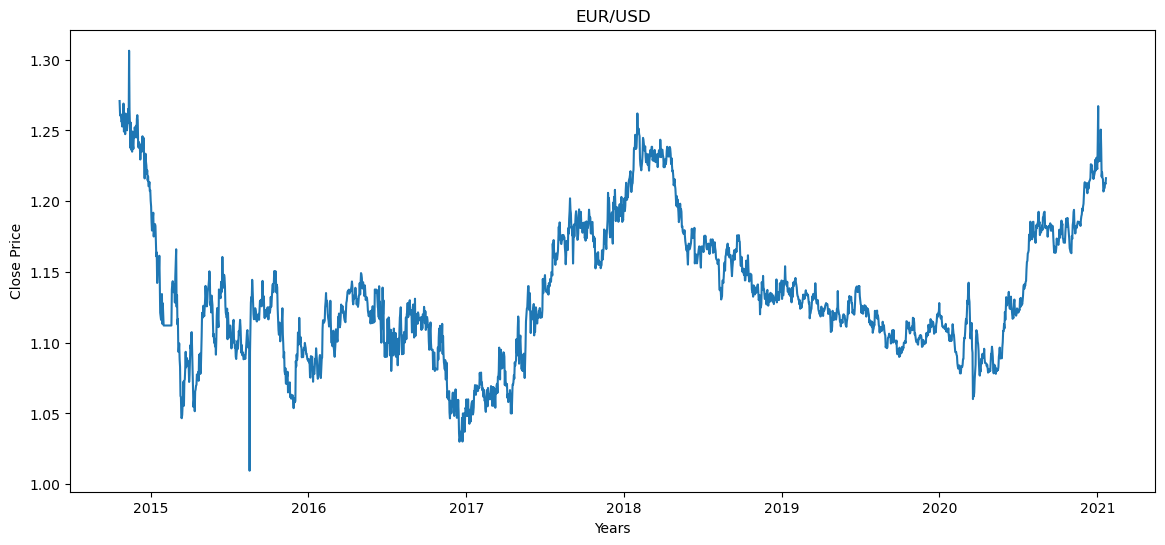

In [23]:
plt.figure(figsize=(14, 6))
plt.plot(df.Close);
plt.title(ticker);
plt.xlabel('Years');
plt.ylabel('Close Price');

# 3. Feature Engineering

In [24]:
df1 = pd.DataFrame([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
df1

,0
0,10
1,20
2,30
3,40
4,50
5,60
6,70
7,80
8,90
9,100


In [25]:
df1['MA_5'] = df1.rolling(5).mean()
df1

,0,MA_5
0,10,NaN
1,20,NaN
2,30,NaN
3,40,NaN
4,50,30.0
5,60,40.0
6,70,50.0
7,80,60.0
8,90,70.0
9,100,80.0


In [26]:
df1

,0,MA_5
0,10,NaN
1,20,NaN
2,30,NaN
3,40,NaN
4,50,30.0
5,60,40.0
6,70,50.0
7,80,60.0
8,90,70.0
9,100,80.0


## 100 days Moving Average

In [28]:
df['MA_100'] = df.Close.rolling(100).mean()
df.head(103)

,Close,MA_100
Date,,
2014-10-21,1.270782,NaN
2014-10-22,1.262023,NaN
2014-10-23,1.260296,NaN
2014-10-24,1.261307,NaN
2014-10-25,1.256431,NaN
...,...,...
2015-01-27,1.134363,NaN
2015-01-28,1.113276,1.220647
2015-01-29,1.127860,1.219218


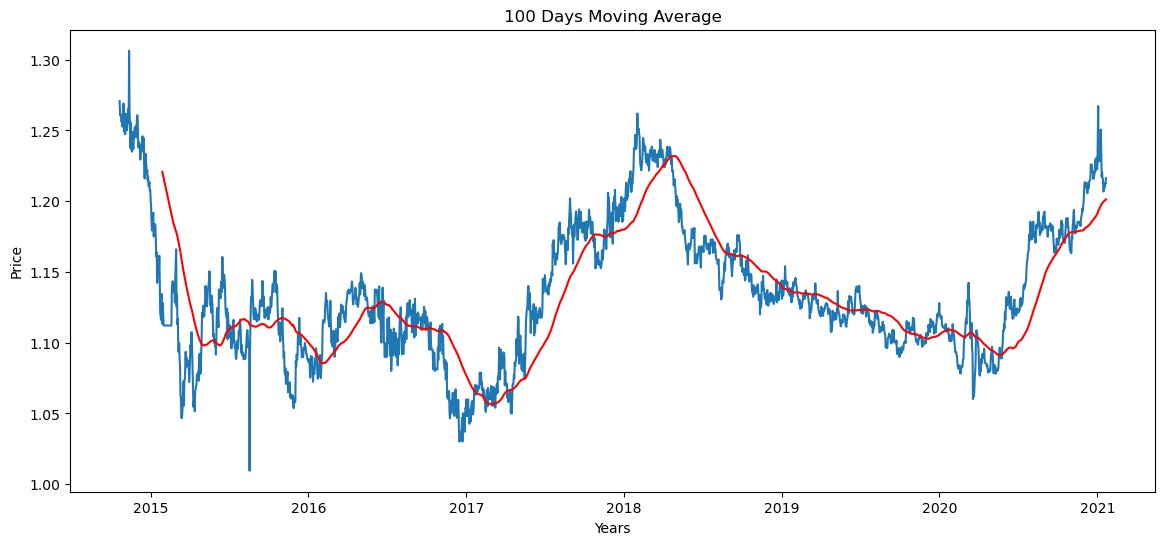

In [29]:
plt.figure(figsize=(14, 6))
plt.plot(df.Close);
plt.plot(df['MA_100'], 'r')
plt.title('100 Days Moving Average');
plt.xlabel('Years');
plt.ylabel('Price');

## 200 days Moving Average

In [30]:
df['MA_200'] = df.Close.rolling(200).mean()
df.head(203)

,Close,MA_100,MA_200
Date,,,
2014-10-21,1.270782,NaN,NaN
2014-10-22,1.262023,NaN,NaN
2014-10-23,1.260296,NaN,NaN
2014-10-24,1.261307,NaN,NaN
2014-10-25,1.256431,NaN,NaN
...,...,...,...
2015-05-07,1.130354,1.098113,NaN
2015-05-08,1.140129,1.098381,1.159514
2015-05-09,1.133761,1.098440,1.158829


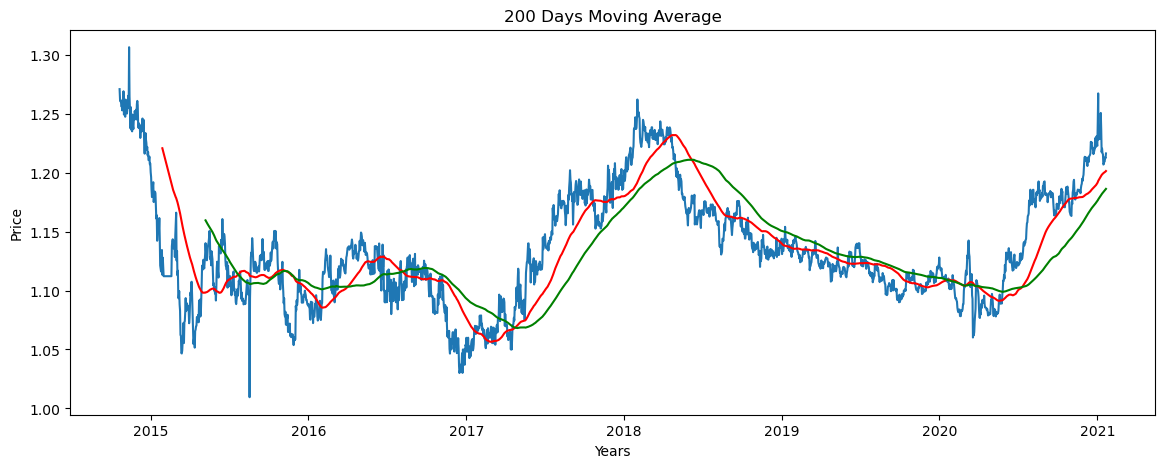

In [31]:
plt.figure(figsize=(14, 5))
plt.plot(df.Close);
plt.plot(df['MA_100'], 'r')
plt.plot(df['MA_200'], 'g')
plt.title('200 Days Moving Average');
plt.xlabel('Years');
plt.ylabel('Price');

### Calculating % changed in each trading session

In [32]:
df

,Close,MA_100,MA_200
Date,,,
2014-10-21,1.270782,NaN,NaN
2014-10-22,1.262023,NaN,NaN
2014-10-23,1.260296,NaN,NaN
2014-10-24,1.261307,NaN,NaN
2014-10-25,1.256431,NaN,NaN
...,...,...,...
2021-01-17,1.209471,1.200087,1.184379
2021-01-18,1.209505,1.200319,1.184820
2021-01-19,1.212952,1.200629,1.185276


In [33]:
df['Percentage Changed'] = df.Close.pct_change()
df[['Close', 'Percentage Changed']]

,Close,Percentage Changed
Date,,
2014-10-21,1.270782,NaN
2014-10-22,1.262023,-0.006892
2014-10-23,1.260296,-0.001369
2014-10-24,1.261307,0.000802
2014-10-25,1.256431,-0.003866
...,...,...
2021-01-17,1.209471,0.001746
2021-01-18,1.209505,0.000028
2021-01-19,1.212952,0.002850


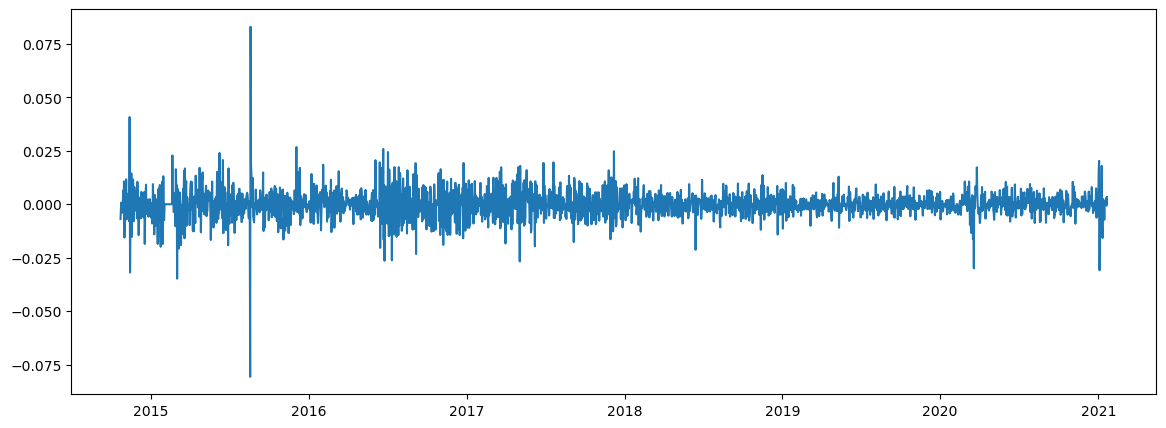

In [34]:
plt.figure(figsize=(14, 5))
plt.plot(df['Percentage Changed']);

# 4. Data Processing

In [35]:
df.shape

(2285, 4)

In [36]:
len(df)

2285

In [39]:
# Splitting data into Training and Testing datasets
data_training = pd.DataFrame(df.Close[0:int(len(df))]) # All Data
# data_testing = pd.DataFrame(df.Close[int(len(df)*0.7): int(len(df))])

print('Data Training')
print(data_training)
# print('Data Testing')
# print(data_testing)

Data Training
               Close
Date                
2014-10-21  1.270782
2014-10-22  1.262023
2014-10-23  1.260296
2014-10-24  1.261307
2014-10-25  1.256431
...              ...
2021-01-17  1.209471
2021-01-18  1.209505
2021-01-19  1.212952
2021-01-20  1.212160
2021-01-21  1.216256

[2285 rows x 1 columns]


In [40]:
data_training

,Close
Date,
2014-10-21,1.270782
2014-10-22,1.262023
2014-10-23,1.260296
2014-10-24,1.261307
2014-10-25,1.256431
...,...
2021-01-17,1.209471
2021-01-18,1.209505
2021-01-19,1.212952


# Scaling down the data between 0 & 1

In [41]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [43]:
data_training_array = scaler.fit_transform(data_traning)
data_training_array

array([[0.88023588],
       [0.85073104],
       [0.84491066],
       ...,
       [0.68541967],
       [0.68274941],
       [0.6965496 ]])

In [44]:
type(data_training_array)

numpy.ndarray

In [45]:
data_training_array.shape

(2285, 1)

# 5. Sequence Creation

In [46]:
# Set window size (number of previous days used to predict the next day)
window_size = 100
# Function for creating training sets from data
def create_dataset(data_training_array, window_size):
    x, y = [], []
    for i in range(window_size, data_training_array.shape[0]):
        x.append(data_training_array[i-window_size:i, 0])  # Inputs: previous “window_size” days
        y.append(data_training_array[i, 0]) # Output: current day
    return np.array(x), np.array(y)


In [47]:
# Create training sets
x_train, y_train = create_dataset(data_training_array, window_size)

In [48]:
# Reshape data for LSTM [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [49]:
x_train

array([[[0.88023588],
        [0.85073104],
        [0.84491066],
        ...,
        [0.39883346],
        [0.4206654 ],
        [0.34962794]],

       [[0.85073104],
        [0.84491066],
        [0.84831677],
        ...,
        [0.4206654 ],
        [0.34962794],
        [0.39875886]],

       [[0.84491066],
        [0.84831677],
        [0.8318905 ],
        ...,
        [0.34962794],
        [0.39875886],
        [0.37366578]],

       ...,

       [[0.58111604],
        [0.58794085],
        [0.55427449],
        ...,
        [0.66658854],
        [0.67369075],
        [0.67380538]],

       [[0.58794085],
        [0.55427449],
        [0.55175885],
        ...,
        [0.67369075],
        [0.67380538],
        [0.68541967]],

       [[0.55427449],
        [0.55175885],
        [0.54318548],
        ...,
        [0.67380538],
        [0.68541967],
        [0.68274941]]])

In [50]:
y_train

array([0.39875886, 0.37366578, 0.34576501, ..., 0.68541967, 0.68274941,
       0.6965496 ])

In [51]:
x_train.ndim

3

In [52]:
y_train.ndim

1

In [53]:
x_train.shape

(2185, 100, 1)

In [54]:
y_train.shape

(2185,)

# 6. Model Building

In [55]:
import tensorflow as tf


In [56]:
# Ml Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input

In [57]:
model = Sequential()

model.add(Input(shape=(100, 1))) # Couche d'entrée
model.add(LSTM(units=128, activation='tanh', return_sequences=True)) # 128 neurons, the LSTM layer will produce an output for each of these layers
model.add(LSTM(units=64)) # This layer takes the output sequence generated by the first layer
model.add(Dense(25))
model.add(Dense(1))

# 7. Model Training

In [58]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50)  # epochs=50

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - loss: 0.0241
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - loss: 0.0016
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - loss: 0.0015
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - loss: 0.0014
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - loss: 0.0013
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - loss: 0.0012
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 44s 167ms/step - loss: 0.0011
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - loss: 0.0010
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - loss: 9.1434e-04
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - loss: 9.3721e-04
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 193ms/step - loss: 9.3711e-04
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 178ms/step - loss: 9.3525e-04
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 7.5722e-04
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - loss: 8.3874e-04
Epoch 15/50
69/69 ━

In [59]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 352,859 (1.35 MB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,240 (918.91 KB)

In [60]:
# save the trained model
model.save('future_stock_prediction_model_with_algo.keras')

# 8. Preparing Test Data

In [61]:
data_traning.tail(100)

,Close
Date,
2020-10-14,1.173277
2020-10-15,1.170732
2020-10-16,1.170828
2020-10-17,1.170741
2020-10-18,1.170591
...,...
2021-01-17,1.209471
2021-01-18,1.209505
2021-01-19,1.212952


In [67]:
# past_100_days' is the last 100-day window of normalized data used for training.
past_100_days = data_traning[-100:]

In [68]:
past_100_days

,Close
Date,
2020-10-14,1.173277
2020-10-15,1.170732
2020-10-16,1.170828
2020-10-17,1.170741
2020-10-18,1.170591
...,...
2021-01-17,1.209471
2021-01-18,1.209505
2021-01-19,1.212952


In [69]:
final_df = pd.concat([past_100_days], ignore_index=True)
final_df

,Close
0,1.173277
1,1.170732
2,1.170828
3,1.170741
4,1.170591
...,...
95,1.209471
96,1.209505
97,1.212952
98,1.212160


In [70]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.09677197],
       [0.07229202],
       [0.07321641],
       [0.07237898],
       [0.07093288],
       [0.14144754],
       [0.18781338],
       [0.23519754],
       [0.1794959 ],
       [0.23247833],
       [0.23987487],
       [0.208259  ],
       [0.17097526],
       [0.13502921],
       [0.09737608],
       [0.03401901],
       [0.022234  ],
       [0.0069963 ],
       [0.00525456],
       [0.        ],
       [0.11721481],
       [0.09730075],
       [0.19151642],
       [0.21405419],
       [0.28043175],
       [0.29483663],
       [0.19034802],
       [0.16331105],
       [0.13415914],
       [0.16299964],
       [0.18610887],
       [0.171108  ],
       [0.18205221],
       [0.2046025 ],
       [0.2157246 ],
       [0.20382373],
       [0.20303788],
       [0.21087509],
       [0.2110169 ],
       [0.20603499],
       [0.18563227],
       [0.22713304],
       [0.25092578],
       [0.26271877],
       [0.30335587],
       [0.28637675],
       [0.31822655],
       [0.335

In [71]:
input_data.shape

(100, 1)

# 9. Making Predictions

In [72]:
predictions = []

# Effectuer 100 prédictions
for _ in range(100):
    # Reshape pour que le modèle accepte les données
    x_input = input_data.reshape(1, -1, 1)  # Reshape en (1, 100, 1)
    
    # Faire la prédiction
    predicted_price = model.predict(x_input)
    
    # Ajouter la prédiction à la liste
    predictions.append(predicted_price[0, 0])
    
    # Mettre à jour la fenêtre de données pour la prochaine prédiction
    input_data = np.append(input_data, predicted_price)[-100:]  # Garder les 100 derniers jours (incluant la nouvelle prédiction)

# Convertir predictions en tableau NumPy pour utiliser .reshape()
predictions = np.array(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

In [73]:
predictions

array([0.50097144, 0.49897167, 0.49610406, 0.49330974, 0.49066886,
       0.48812538, 0.485571  , 0.48290285, 0.48004943, 0.4769756 ,
       0.47367835, 0.4701777 , 0.46650746, 0.46270746, 0.45881808,
       0.45487654, 0.45091516, 0.44696024, 0.44303265, 0.4391475 ,
       0.43531555, 0.43154368, 0.42783555, 0.42419243, 0.4206136 ,
       0.41709703, 0.41363972, 0.410238  , 0.40688777, 0.40358505,
       0.40032578, 0.3971062 , 0.39392278, 0.3907724 , 0.3876524 ,
       0.3845605 , 0.38149488, 0.37845412, 0.37543696, 0.37244284,
       0.36947116, 0.3665218 , 0.36359465, 0.36068982, 0.3578077 ,
       0.3549486 , 0.35211298, 0.3493012 , 0.34651384, 0.3437512 ,
       0.34101382, 0.3383021 , 0.33561644, 0.33295703, 0.33032435,
       0.32771856, 0.3251399 , 0.32258853, 0.32006454, 0.31756812,
       0.31509924, 0.31265795, 0.31024432, 0.30785826, 0.30549982,
       0.30316895, 0.30086562, 0.29858974, 0.29634127, 0.29412004,
       0.29192603, 0.28975925, 0.28761944, 0.28550667, 0.28342

In [74]:
# Reverse normalization of predictions
predicted_prices = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Display predicted_prices
predicted_prices

array([1.2152969, 1.215089 , 1.2147908, 1.2145003, 1.2142258, 1.2139614,
       1.2136958, 1.2134185, 1.2131219, 1.2128023, 1.2124594, 1.2120955,
       1.211714 , 1.211319 , 1.2109146, 1.2105049, 1.210093 , 1.2096819,
       1.2092737, 1.2088697, 1.2084714, 1.2080792, 1.2076937, 1.207315 ,
       1.206943 , 1.2065773, 1.206218 , 1.2058643, 1.205516 , 1.2051727,
       1.2048339, 1.2044991, 1.2041682, 1.2038407, 1.2035164, 1.2031949,
       1.2028762, 1.2025601, 1.2022465, 1.2019352, 1.2016263, 1.2013196,
       1.2010154, 1.2007134, 1.2004137, 1.2001165, 1.1998217, 1.1995294,
       1.1992396, 1.1989524, 1.1986679, 1.198386 , 1.1981068, 1.1978303,
       1.1975566, 1.1972857, 1.1970176, 1.1967524, 1.1964899, 1.1962305,
       1.1959739, 1.19572  , 1.195469 , 1.1952211, 1.1949759, 1.1947335,
       1.1944941, 1.1942575, 1.1940237, 1.1937928, 1.1935648, 1.1933395,
       1.193117 , 1.1928974, 1.1926805, 1.1924665, 1.1922551, 1.1920465,
       1.1918409, 1.1916378, 1.1914374, 1.1912397, 

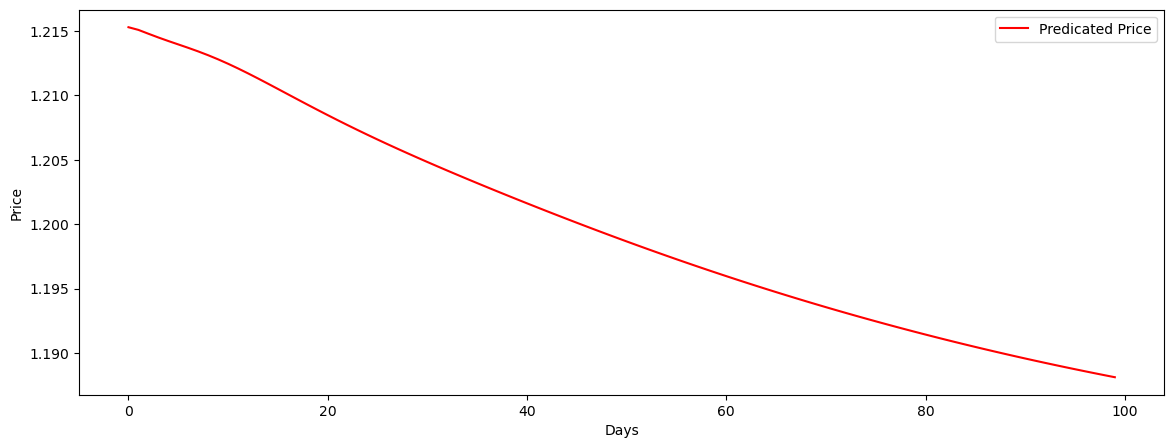

In [77]:
plt.figure(figsize=(14, 5))
plt.plot(predicted_prices, 'r', label='Predicated Price')
plt.xlabel('Days');
plt.ylabel('Price');
plt.legend()